# detección de bordes

En esta clase vamos a explorar el concepto de **gradiente de imagen** y a experimentar con detectores simples de "bordes" (*edges*) y segmentos de recta. Es la base de métodos de descripción de imágenes más potentes.

## bibliotecas y funciones

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow, subplot, title, plot
from skimage.transform import probabilistic_hough_line

from scipy.signal import argrelextrema

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) #/ 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    imshow(x, 'gray')

## gradiente de la imagen

En cada pixel de la imagen hay un vector que indica la dirección hacia la que aumenta la intensidad de luz.

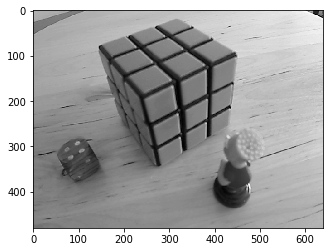

In [2]:
img = readrgb('cube3.png')
g   = gray2float(rgb2gray(img))
imshowg(g);

El gradiente se calcula normalmente tras un suavizado, para obtener los cambios de intensidad a la escala de detalle deseada.

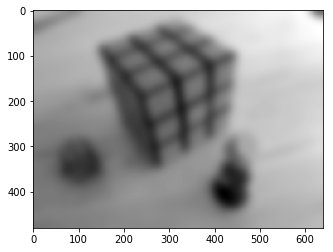

In [3]:
s = cv.GaussianBlur(g,(0,0),10)
imshowg(s)

In [4]:
def grad(x):
    gx =  cv.Sobel(x,-1,1,0)/8
    gy = -cv.Sobel(x,-1,0,1)/8
    return gx,gy

gx,gy = grad(s)

La máscara de Sobel produce un valor proporcional a la derivada. Dividimos por 8 para conseguir el valor real.

In [5]:
np.outer(np.arange(10),[1,1,1,1,1]).T

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [6]:
grad(np.outer(np.arange(10),[1,1,1,1,1]).T.astype(np.uint8))[0]

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.]])

Mostramos por separado una imagen con todas las componentes $\nabla_x$ y otra con todas las componentes $\nabla_y$:

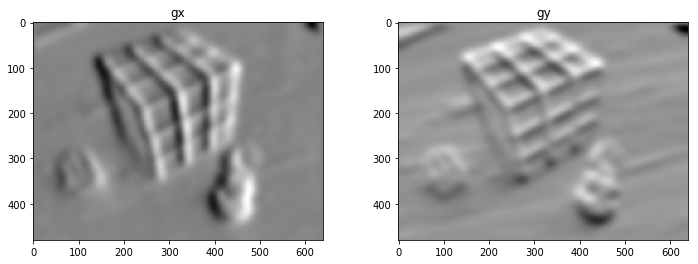

In [7]:
fig(12,4)
subplot(1,2,1); imshowg(gx); plt.title('gx')
subplot(1,2,2); imshowg(gy); plt.title('gy');

Es interesante también mostrar el gradiente como campo vectorial:

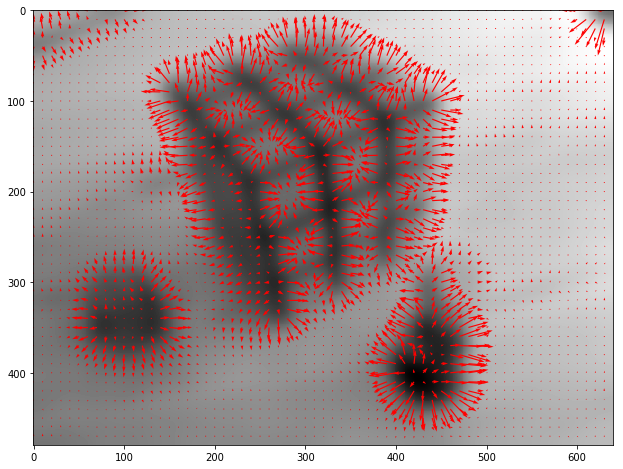

In [8]:
# para generar un "grid" con coordenadas
def dom(sz, by=1):
    r,c = sz
    x,y = np.meshgrid(range(0,c,by),range(0,r,by))
    return x,y

# saltamos de 10 en 10 para no poner demasiadas flechas en la imagen
x,y = dom(s.shape,10)

r1 = y
c1 = x
r2 = gy[r1,c1]
c2 = gx[r1,c1]

fig(12,8)
imshowg(s)
plt.quiver(c1, r1, c2, r2, color='Red', width=0.002, scale=1/8,  scale_units='xy');

Las zonas uniformes tienen gradiente nulo, y en las zonas de pendiente pronunciada vemos que los vectores apuntan hacia las zonas más claras de la imagen.

## bordes

Veamos en detalle los pixels de la fila 200 de la imagen (estirados en vertical para verlos mejor):

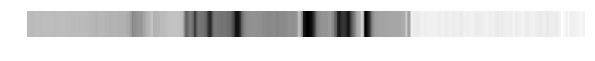

In [9]:
franja = np.zeros([30,s.shape[1]]) + g[200]
fig(10,4)

imshowg(franja); plt.axis('off');

La misma fila suavizada:

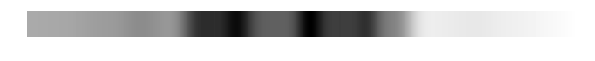

In [10]:
franja = np.zeros([30,s.shape[1]]) + s[200]
fig(10,4)

imshowg(franja); plt.axis('off');

Comparamos los perfiles de niveles de gris en esa fila.

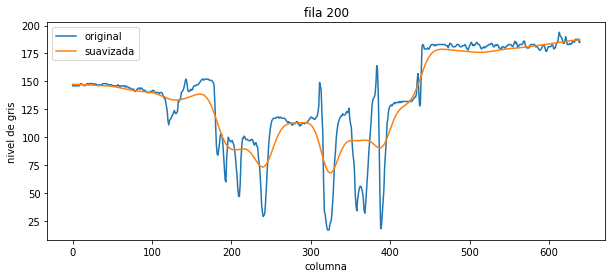

In [11]:
fig(10,4)
plt.plot(g[200],label='original');
plt.plot(s[200],label='suavizada');
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Nuestro problema es encontrar la posición precisa de los bordes teniendo en cuenta que el "escalón" de nivel de gris que observamos en la imagen puede ser bastante gradual.

Veamos la derivada de la imagen suavizada en esa fila ($\nabla_x$)

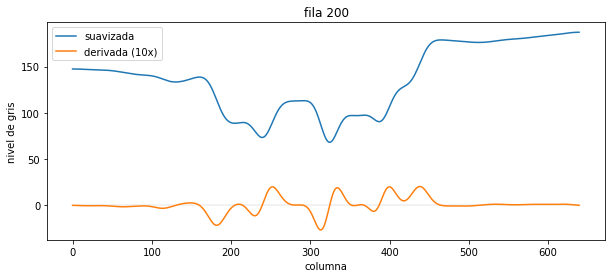

In [12]:
fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(10*gx[200],label='derivada (10x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Los extremos de la derivada ocurren en los puntos de máxima pendiente de nivel de gris, que son la mejor estimación de la posición del borde.

[149 252 334 400 438]
[113 182 230 313 380]


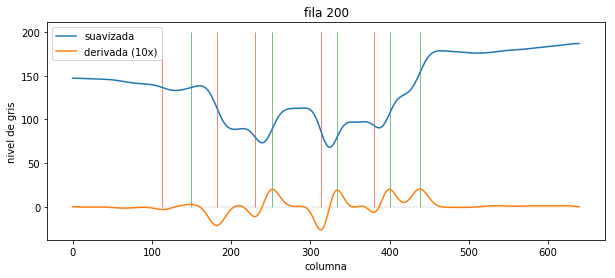

In [13]:
pix = gx[200]

THG = 0.2
edgesp = argrelextrema(pix*(pix> THG),np.greater,order=5)[0]
edgesn = argrelextrema(pix*(pix<-THG),np.less,   order=5)[0]

print(edgesp)
print(edgesn)

fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(10*gx[200],label='derivada (10x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.vlines(edgesp,ymin=0,ymax=200,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=0,ymax=200,colors='red',lw=0.5);
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

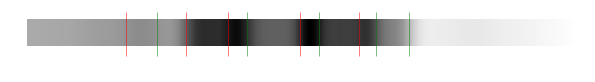

In [14]:
franja = np.zeros([30,s.shape[1]]) + s[200]
fig(10,4)

imshowg(franja); plt.axis('off');
#imshowg(grad(franja)[0]); plt.axis('off');
plt.vlines(edgesp,ymin=-10,ymax=40,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=-10,ymax=40,colors='red',lw=0.5);

Si no se suaviza la imagen, o el nivel de suavizado es muy pequeño (el operador de Sobel realiza implícitamente un suavizado leve), aparecen muchos más bordes debido al ruido de imagen o a detalles de tamaño pequeño.

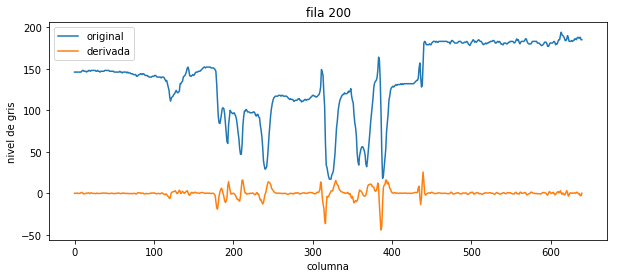

In [15]:
fig(10,4)
plt.plot(g[200],label='original');
plt.plot(grad(g)[0][200],label='derivada');
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

[132 142 185 194 212 244 310 329 359 373 382 392 439 612 620]
[120 145 180 190 208 237 316 352 386 436 596 622 637]


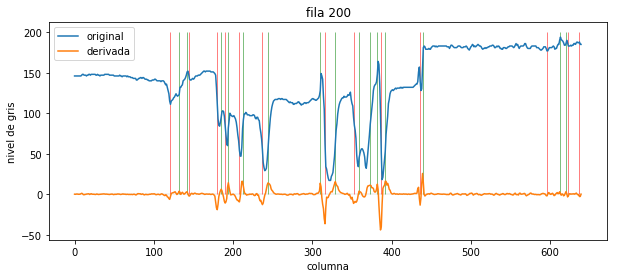

In [16]:
pix = grad(g)[0][200]

THG = 2
edgesp = argrelextrema(pix*(pix> THG),np.greater,order=5)[0]
edgesn = argrelextrema(pix*(pix<-THG),np.less,   order=5)[0]

print(edgesp)
print(edgesn)

fig(10,4)
plt.plot(g[200],label='original');
plt.plot(pix,label='derivada');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.vlines(edgesp,ymin=0,ymax=200,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=0,ymax=200,colors='red',lw=0.5);
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

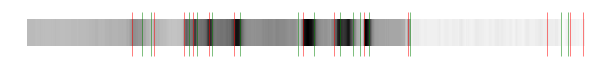

In [17]:
franja = np.zeros([30,s.shape[1]]) + g[200]
fig(10,4)

imshowg(franja); plt.axis('off');
#imshowg(grad(franja)[0]); plt.axis('off');
plt.vlines(edgesp,ymin=-10,ymax=40,colors='green',lw=0.5);
plt.vlines(edgesn,ymin=-10,ymax=40,colors='red',lw=0.5);

La detección de bordes siempre se hace sobre un determinado nivel de suavizado o escala de detalle $\sigma$.

Veamos la segunda derivada. Sus *cruces por cero* corresponden con los extremos de primera derivada y también indican la posición de los bordes.

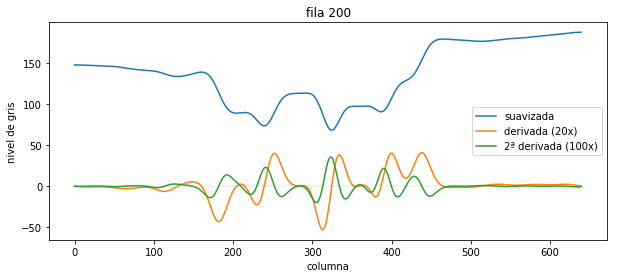

In [18]:
gxx,_ = grad(gx)

fig(10,4)
plt.plot(s[200],label='suavizada');
plt.plot(20*gx[200],label='derivada (20x)');
plt.plot(100*gxx[200],label='2ª derivada (100x)');
plt.hlines([0],xmin=0,xmax=640,lw=0.1)
plt.title('fila 200')
plt.xlabel('columna'); plt.ylabel('nivel de gris'); plt.legend();

Como la imagen es una función de dos variables tiene 4 derivadas segundas (las dos cruzadas coinciden).

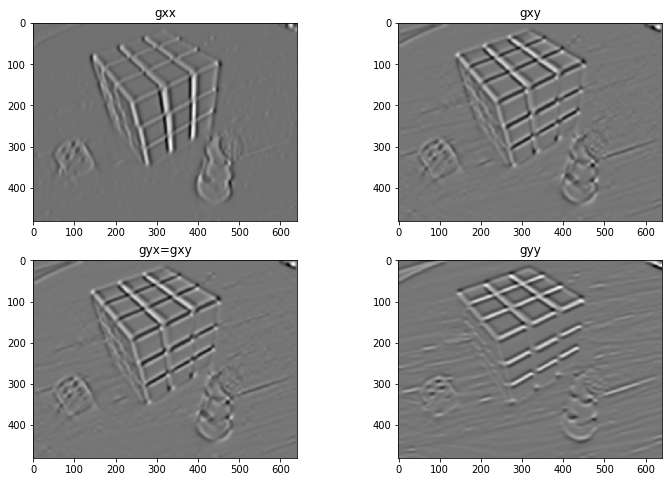

In [19]:
gx,gy = grad(cv.GaussianBlur(g,(0,0),4))

gxx,gxy = grad(gx)
gyx,gyy = grad(gy)

fig(12,8)
subplot(2,2,1); imshowg(gxx); plt.title('gxx')
subplot(2,2,2); imshowg(gxy); plt.title('gxy')
subplot(2,2,3); imshowg(gyx); plt.title('gyx=gxy')
subplot(2,2,4); imshowg(gyy); plt.title('gyy');

Con ellas conseguimos dos operadores importantes: Laplaciano y Hessiano:

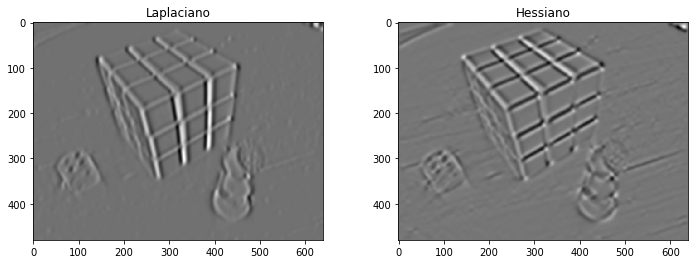

In [20]:
L = gxx+gyy
H = gxx*gyy-gxy**2

fig(12,4)
subplot(1,2,1); imshowg(gxx); plt.title('Laplaciano')
subplot(1,2,2); imshowg(gxy); plt.title('Hessiano');

Estos operadores se utilizarán más adelante para describir localmente la estructura de la imagen.

## operador de Marr–Hildreth

Extendiendo el razonamiento anterior al caso de 2 dimensiones llegamos a un primer método de detección de bordes ([Marr-Hildreth](http://rspb.royalsocietypublishing.org/content/207/1167/187)). Se basa en encontrar los cruces por cero del Laplaciano de la imagen, previamente suavizada con un filtro gaussiano.

In [21]:
# ejemplo

Las operaciones de suavizado gaussiano y Laplaciano se pueden realizar simultaneamente con el operador operador $LoG(\sigma)$ que tiene forma de [sombrero mexicano](https://en.wikipedia.org/wiki/Mexican_hat_wavelet) invertido. Su efecto puede aproximarse bien mediante la diferencia de dos suavizados de sigma apropiado ([DoG](https://en.wikipedia.org/wiki/Difference_of_Gaussians)), que normalmente se calculan eficientemente en una cascada.

## gradiente en forma polar

## operador de Canny

Es el [método estándar](https://en.wikipedia.org/wiki/Canny_edge_detector) de detección precisa de bordes. Busca los máximos locales del módulo del gradiente *en la dirección* del gradiente.

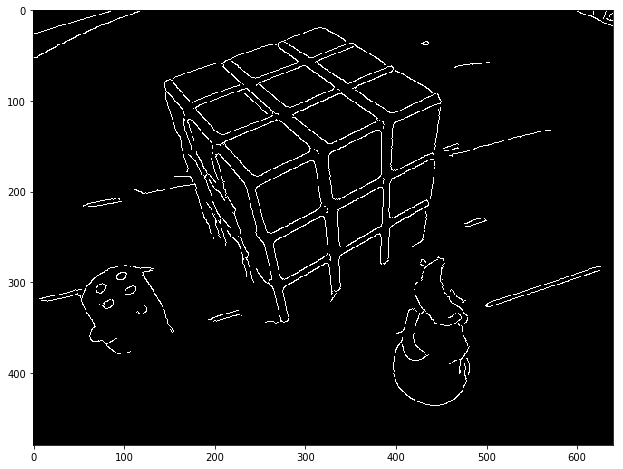

In [22]:
edges = cv.Canny(cv.GaussianBlur(g,(0,0),2).astype(np.uint8),20,60)

fig(12,8)
plt.imshow(edges, 'gray', interpolation='nearest');

Los puntos de borde detectados se podrían guardar en listas, o hacer lo que se quiera con ellos.

### información en los bordes

Casi toda la información de la imagen está en los puntos de borde. El resto es uniforme y se podría deducir.

Se puede reconstruir una versión aceptable de la imagen mediante "inpainting" de los bordes de Canny. Los ensanchamos un poco con una [operación morfológica](http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html#gsc.tab=0) de dilatación para que haya información de color más o menos definida a cada lado.

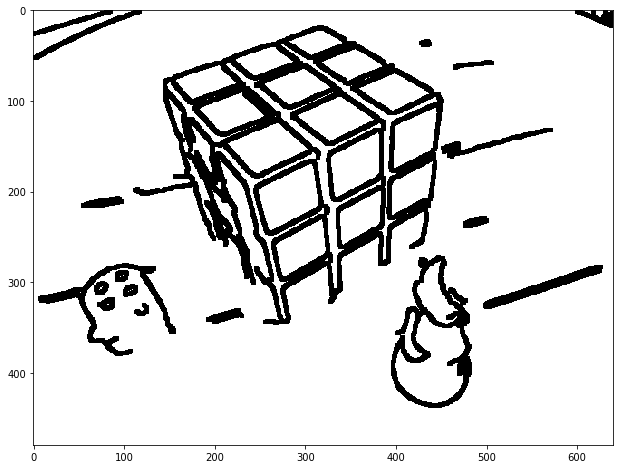

In [23]:
ker = np.ones((5,5),np.uint8)

#mask = 255-edges
mask = 255-cv.dilate(edges, ker)
fig(12,8)
imshowg(mask)

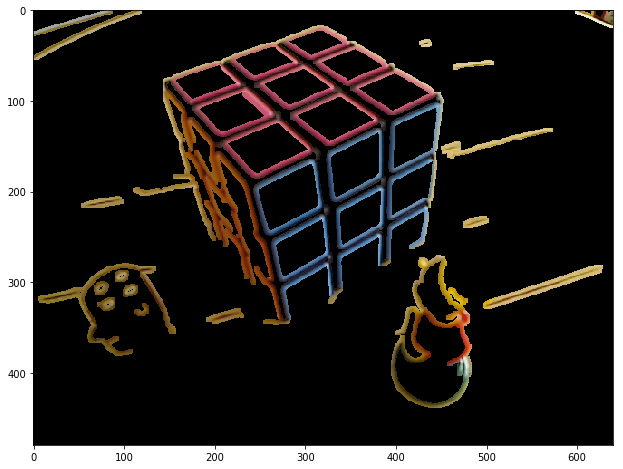

In [24]:
m3 = (255-mask).reshape(480,640,1).astype(bool)
xx = np.zeros([480,640,3],dtype=np.uint8)
np.copyto(xx, img, where = m3)

fig(12,8)
imshow(xx);

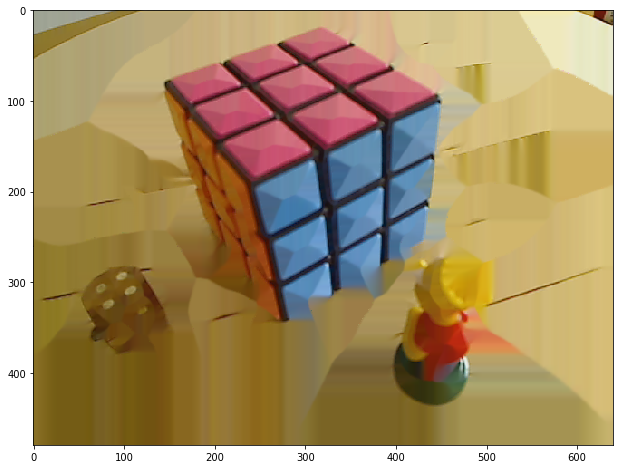

In [25]:
dst = cv.inpaint(img,mask,3,cv.INPAINT_NS);

fig(12,8)
imshow(dst);

## histograma de orientaciones de gradiente (HOG)

## segmentos de recta

En algunas aplicaciones nos gustaría detectar bordes rectos. Una forma de conseguirlo es la "Transformada de Hough". La idea es construir un espacio discretizado de los parámetros de una recta y cada punto de borde vota en todas las rectas que pasan por él.

Partimos de los bordes de Canny (o de cualquier otro filtro de alta frecuencia).

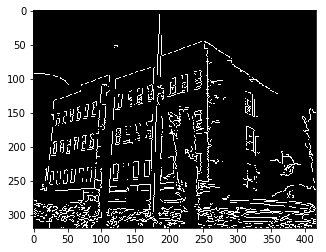

In [26]:
img = readrgb('pano000.jpg')
g = cv.GaussianBlur(rgb2gray(img),(-1,1),1)

edges = cv.Canny(g,30,160)
imshowg(edges)

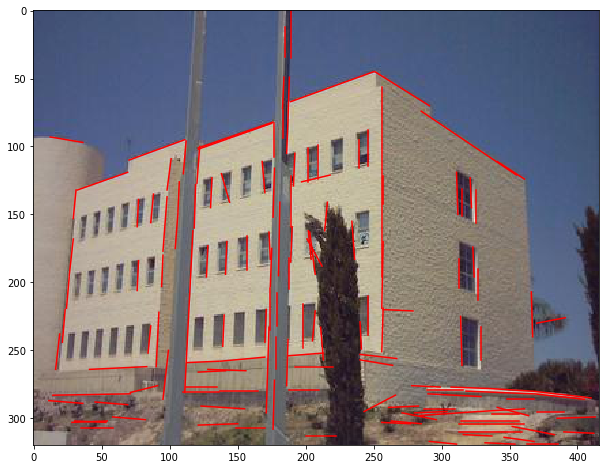

In [27]:
# implementación de scikit-image

lines = probabilistic_hough_line(edges, 
                                 threshold=10, 
                                 line_length=20,
                                 line_gap=3)
fig(12,8)
imshow(img)
ax = plt.axis()

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]),'r')

plt.axis(ax);

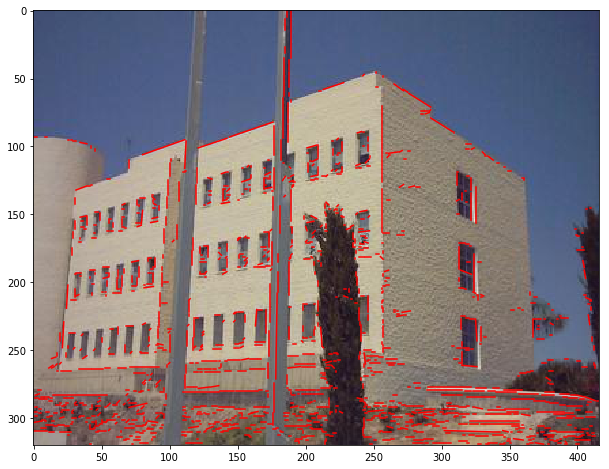

In [28]:
# implementación de OpenCV

minLineLength = 100
maxLineGap = 1
votes = 30
lines = cv.HoughLinesP(edges,1,1*np.pi/180,
                       votes,minLineLength,maxLineGap)
lines = lines.reshape(lines.shape[0],4)

fig(12,8)
imshow(img)
ax = plt.axis()

for x1,y1,x2,y2 in lines:
    plt.plot([x1, x2], [y1, y2],'r')    

plt.axis(ax);

## misc

### inpainting

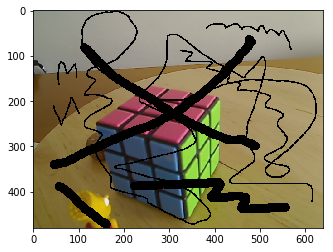

In [29]:
img = readrgb('cube4b.png')
imshow(img);

Intentamos recuperar las zonas negras. Para ello construimos la máscara de posiciones en las que debe actuar el algoritmo de inpainting.

In [30]:
m = img == 0
print(m.shape)
#imshow(m,cmap=cm.gray);

(480, 640, 3)


Es una máscara de tres canales. Nos interesan los pixeles en los que todos son cero.

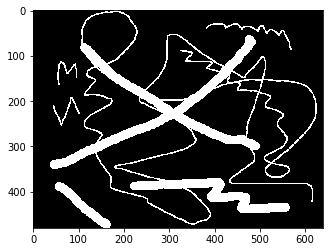

In [31]:
# la función de inpainting trabaja con mask numérica (no lógica)
#mask = np.logical_and(m[:,:,0],m[:,:,1],m[:,:,2]).astype(np.uint8)
mask = (m[:,:,0] & m[:,:,1] & m[:,:,2]).astype(np.uint8)
imshow(mask,'gray');

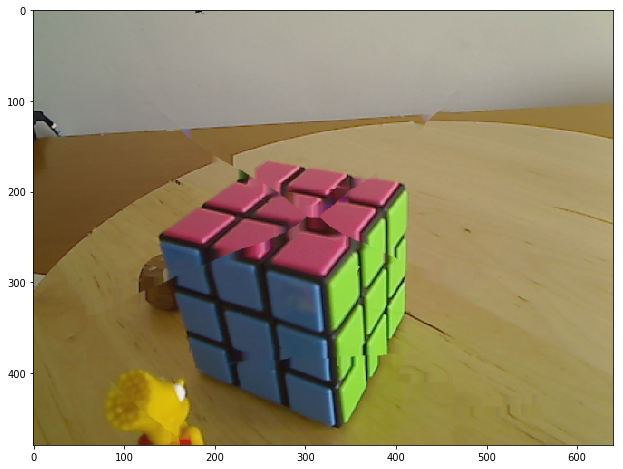

In [32]:
dst = cv.inpaint(img,mask,1,cv.INPAINT_NS)
fig(12,8)
imshow(dst);